In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
df = pd.read_csv("/content/Chandigarh_AQIBulletins.csv")   # ← change file name

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

TASK 1 - EDA

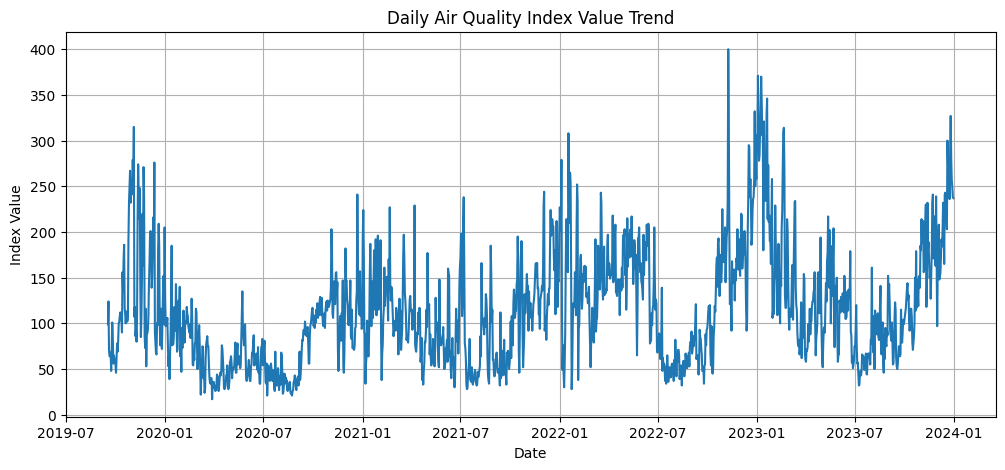

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Code to define df, ensuring it's available for plotting
df = pd.read_csv("/content/Chandigarh_AQIBulletins.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['Index Value'])
plt.title("Daily Air Quality Index Value Trend")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.grid()
plt.show()

In [5]:
print("\nMissing Values:")
print(df.isnull().sum())

print("\nDescribe Index Value:")
print(df['Index Value'].describe())

# Detect outliers using Z-score
z = (df['Index Value'] - df['Index Value'].mean())/df['Index Value'].std()
outliers = df[z > 3]
print("\nAbnormal Readings:")
print(outliers)



Missing Values:
date                   0
City                   0
No. Stations           0
Air Quality            0
Index Value            0
Prominent Pollutant    0
dtype: int64

Describe Index Value:
count    1558.000000
mean      114.555199
std        62.492588
min        17.000000
25%        66.000000
50%       104.000000
75%       148.000000
max       400.000000
Name: Index Value, dtype: float64

Abnormal Readings:
           date        City  No. Stations Air Quality  Index Value  \
46   2019-11-04  Chandigarh           1.0   Very Poor          315   
845  2022-01-17  Chandigarh           1.0   Very Poor          308   
1140 2022-11-09  Chandigarh           3.0   Very Poor          400   
1141 2022-11-10  Chandigarh           3.0   Very Poor          322   
1189 2022-12-28  Chandigarh           2.0   Very Poor          332   
1193 2023-01-01  Chandigarh           2.0   Very Poor          306   
1195 2023-01-03  Chandigarh           2.0   Very Poor          371   
1199 2023-01-07

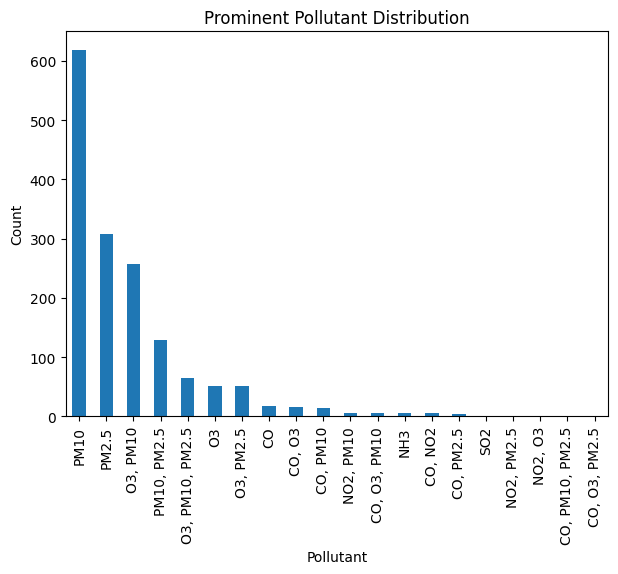

In [6]:
plt.figure(figsize=(7,5))
df['Prominent Pollutant'].value_counts().plot(kind='bar')
plt.title("Prominent Pollutant Distribution")
plt.xlabel("Pollutant")
plt.ylabel("Count")
plt.show()


TASK 2 - SUPERVISED LEARNING(TIME SERIES FORECASTE)

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

data = df[['Index Value']].values

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

def create_window(data, window=5):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

window_size = 7   # past 7 days → predict next day
X, y = create_window(data_scaled, window_size)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window_size, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0176 - val_loss: 0.0218
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - val_loss: 0.0189
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0077 - val_loss: 0.0242
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - val_loss: 0.0193
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0175
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0066 - val_loss: 0.0198
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062 - val_loss: 0.0183
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0205
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0255
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - val_loss: 0.0168
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0164
Epoch 12/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
y_test_actual = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_actual, pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, pred))

print("MAE =", mae)
print("RMSE =", rmse)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE = 23.782341371395198
RMSE = 31.985713344156178


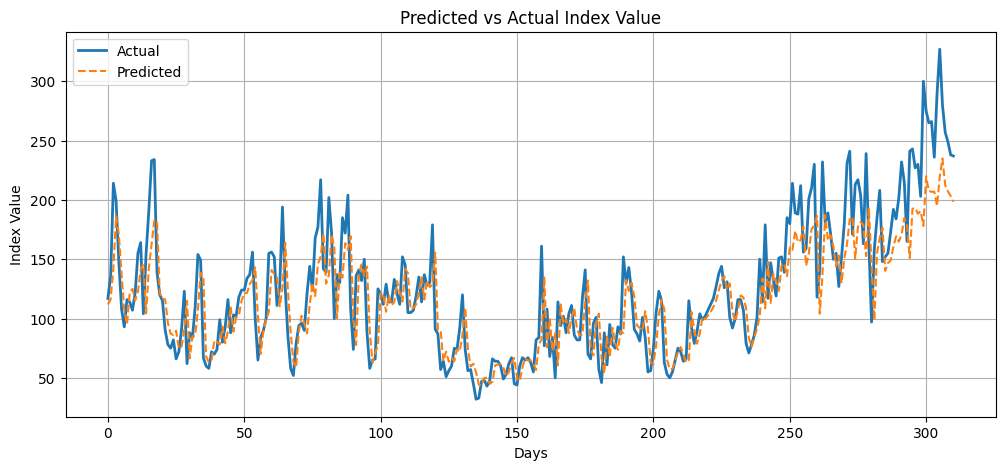

In [16]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='dashed')
plt.title("Predicted vs Actual Index Value")
plt.xlabel("Days")
plt.ylabel("Index Value")
plt.legend()
plt.grid()
plt.show()


TASK 3 - UNSUPERVIED LEARNING(K MEANS CLUSTERING)

In [17]:
X_cluster = df[['Index Value']]


In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

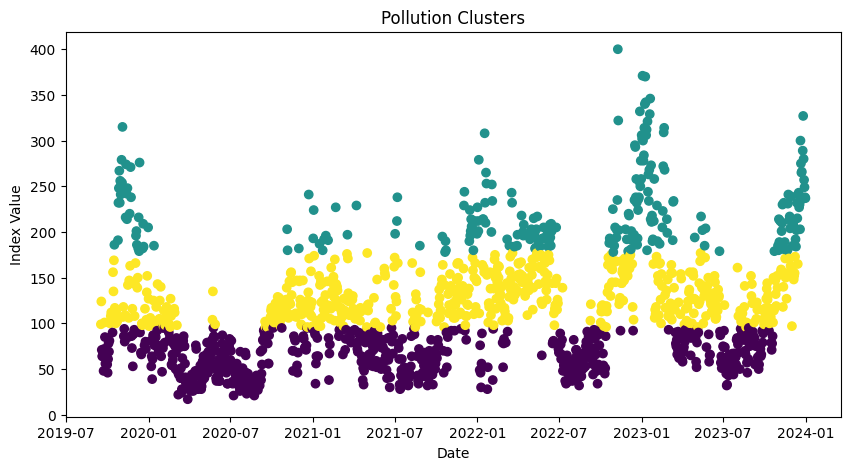

In [21]:
plt.figure(figsize=(10,5))
plt.scatter(df['date'], df['Index Value'], c=df['Cluster'], cmap='viridis')
plt.title("Pollution Clusters")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.show()

In [22]:
print(df.groupby('Cluster')['Index Value'].mean().sort_values())


Cluster
0     61.705109
2    128.890127
1    225.575510
Name: Index Value, dtype: float64


TASK 4 - AI TASK

In [24]:
df['Month'] = df['date'].dt.to_period('M')
monthly_avg = df.groupby('Month')['Index Value'].mean()
print(monthly_avg)

Month
2019-09     76.416667
2019-10    134.677419
2019-11    162.000000
2019-12    142.533333
2020-01     93.580645
2020-02     92.379310
2020-03     53.387097
2020-04     39.862069
2020-05     66.354839
2020-06     57.068966
2020-07     44.387097
2020-08     34.548387
2020-09     76.033333
2020-10    111.935484
2020-11    115.333333
2020-12    114.774194
2021-01    123.290323
2021-02    125.535714
2021-03    111.900000
2021-04     89.466667
2021-05     87.466667
2021-06     82.000000
2021-07     77.225806
2021-08     88.200000
2021-09     55.366667
2021-10    114.838710
2021-11    128.533333
2021-12    160.161290
2022-01    150.064516
2022-02    136.814815
2022-03    144.096774
2022-04    159.100000
2022-05    169.709677
2022-06    145.866667
2022-07     58.354839
2022-08     56.741935
2022-09     72.000000
2022-10    127.000000
2022-11    176.766667
2022-12    210.580645
2023-01    263.354839
2023-02    175.678571
2023-03    118.096774
2023-04    108.933333
2023-05    128.225806
2023

In [25]:
def categorize(aqi):
    if aqi < 60:
        return "Clean"
    elif aqi < 120:
        return "Moderate"
    else:
        return "High Pollution"

season_category = monthly_avg.apply(categorize)
print(season_category)


Month
2019-09          Moderate
2019-10    High Pollution
2019-11    High Pollution
2019-12    High Pollution
2020-01          Moderate
2020-02          Moderate
2020-03             Clean
2020-04             Clean
2020-05          Moderate
2020-06             Clean
2020-07             Clean
2020-08             Clean
2020-09          Moderate
2020-10          Moderate
2020-11          Moderate
2020-12          Moderate
2021-01    High Pollution
2021-02    High Pollution
2021-03          Moderate
2021-04          Moderate
2021-05          Moderate
2021-06          Moderate
2021-07          Moderate
2021-08          Moderate
2021-09             Clean
2021-10          Moderate
2021-11    High Pollution
2021-12    High Pollution
2022-01    High Pollution
2022-02    High Pollution
2022-03    High Pollution
2022-04    High Pollution
2022-05    High Pollution
2022-06    High Pollution
2022-07             Clean
2022-08             Clean
2022-09          Moderate
2022-10    High Pollution
2022-1

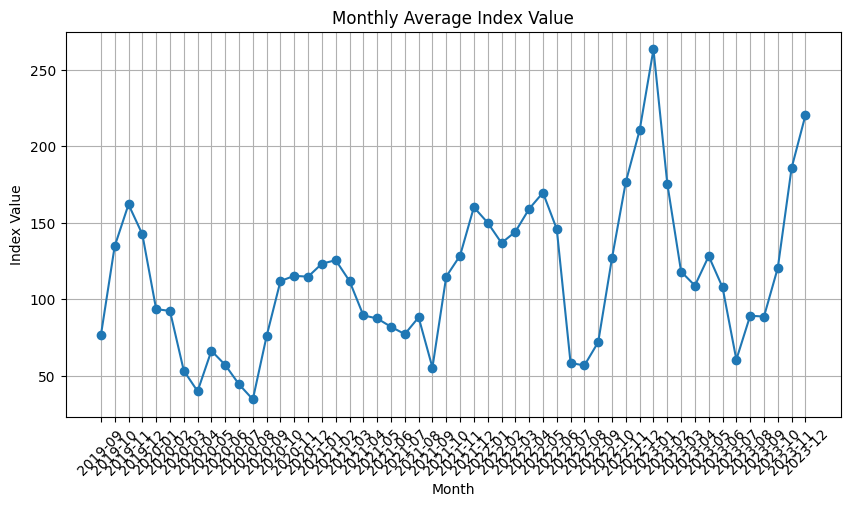

In [26]:
plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index.astype(str), monthly_avg.values, marker='o')
plt.title("Monthly Average Index Value")
plt.xlabel("Month")
plt.ylabel("Index Value")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [27]:
print("\nAI Seasonal Insight:")

for month, cat in season_category.items():
    print(f"{month}: {cat}")



AI Seasonal Insight:
2019-09: Moderate
2019-10: High Pollution
2019-11: High Pollution
2019-12: High Pollution
2020-01: Moderate
2020-02: Moderate
2020-03: Clean
2020-04: Clean
2020-05: Moderate
2020-06: Clean
2020-07: Clean
2020-08: Clean
2020-09: Moderate
2020-10: Moderate
2020-11: Moderate
2020-12: Moderate
2021-01: High Pollution
2021-02: High Pollution
2021-03: Moderate
2021-04: Moderate
2021-05: Moderate
2021-06: Moderate
2021-07: Moderate
2021-08: Moderate
2021-09: Clean
2021-10: Moderate
2021-11: High Pollution
2021-12: High Pollution
2022-01: High Pollution
2022-02: High Pollution
2022-03: High Pollution
2022-04: High Pollution
2022-05: High Pollution
2022-06: High Pollution
2022-07: Clean
2022-08: Clean
2022-09: Moderate
2022-10: High Pollution
2022-11: High Pollution
2022-12: High Pollution
2023-01: High Pollution
2023-02: High Pollution
2023-03: Moderate
2023-04: Moderate
2023-05: High Pollution
2023-06: Moderate
2023-07: Moderate
2023-08: Moderate
2023-09: Moderate
2023-1